<a href="https://colab.research.google.com/github/yonatanrtt/sentiment-analysis/blob/main/P_f3_classifiction_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h2>Unsupervied Classification</h2>

In this notebook, unsupervised algorithms will be tested

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertModel
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import time
import matplotlib.cm as cm
from sklearn import metrics
from sentence_transformers import SentenceTransformer
from yellowbrick.cluster import SilhouetteVisualizer

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import  drive
drive.mount("/drive")
data = pd.read_csv("/drive/My Drive/data.csv")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


<b><h3>First Step:</h3>

the first step of this note is trying to use dbscan algorithm using some epsilon and two text representation options


In [ ]:
def clean_text(txt):
    
    # set new line as a word
    txt = re.sub(r'<br />', " enter ", txt)  
    txt =re.sub(r'<br/>', " enter ", txt)

    # remove all other hatml tags
    txt = re.sub(r'<.*?>', ' ', txt)
    
    # set all text as lower case
    txt = txt.strip().lower()
    
    # separate specific characters like punctuation from words for using word base algorithms
    special_chars = '!"\/#$%&()*+,-./:;<=>?@[]^_`{|}~'
    special_chars = special_chars + "'"
    special_chars_dict = dict((c, " ") for c in special_chars)
    str_map = str.maketrans(special_chars_dict)
    txt = txt.translate(str_map)
    
    # remove digits and spaces
    all_words = [word for word in txt.split(sep = " ") if not word.isdigit()]
    all_words_not_spaces = filter(lambda item: item, all_words)
    txt = ' '.join(all_words_not_spaces)
    txt = txt.strip()
    
    return txt

In [ ]:
data["review"] = data["review"]
data["sentiment"] = data["sentiment"].replace("positive", 1).replace("negative", 0)

df_train, df_test = train_test_split(data, test_size=0.5, random_state=42)

X = df_train["review"]
y = df_train["sentiment"]

In [ ]:
vectorizer = CountVectorizer(
    stop_words="english",
    preprocessor=clean_text,
    max_df=0.9,
    min_df=5
)

In [ ]:
training_features = vectorizer.fit_transform(X)

<b>max length of the SBERT model is 300 out of computation resource limits

In [ ]:
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
sbert_model.max_seq_length = 300

In [ ]:
embedded = sbert_model.encode(list(X))

In [ ]:
def dbscan_evaluate(model, evaluation, input, epsilon_size):
  labels = dbscan.labels_

  num_clusters = len(np.unique(labels) )
  num_noise = np.sum(np.array(labels) == -1, axis=0)

  silhouette_avg = silhouette_score(input, labels)
  evaluation.append(silhouette_avg)
  print('epsilon size: %.3f. noise points: %d.clusters: %d. silhouette avarage: %0.3f.' % (epsilon_size, num_noise, num_clusters, silhouette_avg))

  labels_lst = list(labels)

  if num_clusters < 6:
    for label in np.unique(labels):
      print('label: %d. num of items: %d.' % (label, labels_lst.count(label)))
  print("\n")

In [ ]:
dbscan_evaluation = []
dbscan_based_bert_evaluation = []


epsilon_sizes = [0.07, 0.2, 0.7, 2, 5, 10, 20, 30, 40, 45, 50, 55]

<b>the next cell will display the result of dbscan with 13 different epsilon sizes. <br/><br/>the reviews will be represented by B.O.W. ( bag of words )

In [ ]:
for idx, epsilon_size in enumerate(epsilon_sizes):
    time.sleep(2)
    dbscan = DBSCAN(eps=epsilon_size, min_samples=2).fit(training_features)
    clumn, row = divmod(idx,2)
    dbscan_evaluate(dbscan, dbscan_evaluation, training_features, epsilon_size) 

epsilon size: 0.070. noise points: 24800.clusters: 100. silhouette avarage: -0.310.


epsilon size: 0.200. noise points: 24800.clusters: 100. silhouette avarage: -0.310.


epsilon size: 0.700. noise points: 24800.clusters: 100. silhouette avarage: -0.310.


epsilon size: 2.000. noise points: 24798.clusters: 101. silhouette avarage: -0.310.


epsilon size: 5.000. noise points: 24236.clusters: 101. silhouette avarage: -0.285.


epsilon size: 10.000. noise points: 12755.clusters: 47. silhouette avarage: -0.082.


epsilon size: 20.000. noise points: 1770.clusters: 10. silhouette avarage: 0.298.


epsilon size: 30.000. noise points: 209.clusters: 3. silhouette avarage: 0.567.
label: -1. num of items: 209.
label: 0. num of items: 24789.
label: 1. num of items: 2.


epsilon size: 40.000. noise points: 15.clusters: 2. silhouette avarage: 0.716.
label: -1. num of items: 15.
label: 0. num of items: 24985.


epsilon size: 45.000. noise points: 9.clusters: 2. silhouette avarage: 0.713.
label: -1. 

<b>DbScan - B.O.W. - it can been seen that although the silhouette score is better as the epsilon size increase,<br/> the distribution of the reviews between the clusters does not make any sence 

<b>the next cell will display the result of dbscan with the same 13 different epsilon sizes of the previous section. <br/><br/>the reviews will be represented by SBERT ( sentence BERT )

In [ ]:
for idx, epsilon_size in enumerate(epsilon_sizes):
    time.sleep(2)
    dbscan_based_bert = DBSCAN(eps=epsilon_size, min_samples=2).fit(embedded)
    clumn, row = divmod(idx,2)
    dbscan_evaluate(dbscan_based_bert, dbscan_based_bert_evaluation, embedded, epsilon_size) 

epsilon size: 0.070. noise points: 2.clusters: 2. silhouette avarage: 0.213.
label: -1. num of items: 2.
label: 0. num of items: 24998.


epsilon size: 0.200. noise points: 2.clusters: 2. silhouette avarage: 0.213.
label: -1. num of items: 2.
label: 0. num of items: 24998.


epsilon size: 0.700. noise points: 2.clusters: 2. silhouette avarage: 0.213.
label: -1. num of items: 2.
label: 0. num of items: 24998.


epsilon size: 2.000. noise points: 2.clusters: 2. silhouette avarage: 0.213.
label: -1. num of items: 2.
label: 0. num of items: 24998.


epsilon size: 5.000. noise points: 2.clusters: 2. silhouette avarage: 0.213.
label: -1. num of items: 2.
label: 0. num of items: 24998.


epsilon size: 10.000. noise points: 2.clusters: 2. silhouette avarage: 0.213.
label: -1. num of items: 2.
label: 0. num of items: 24998.


epsilon size: 20.000. noise points: 2.clusters: 2. silhouette avarage: 0.213.
label: -1. num of items: 2.
label: 0. num of items: 24998.


epsilon size: 30.000. noise poin

<b>DbScan - SBERT - it can been seen that although the silhouette score does not change at all.
the distribution of the reviews between the clusters does not make any sence. 

<b>next cell will display the silhouette score of every epsilon size for every text representation

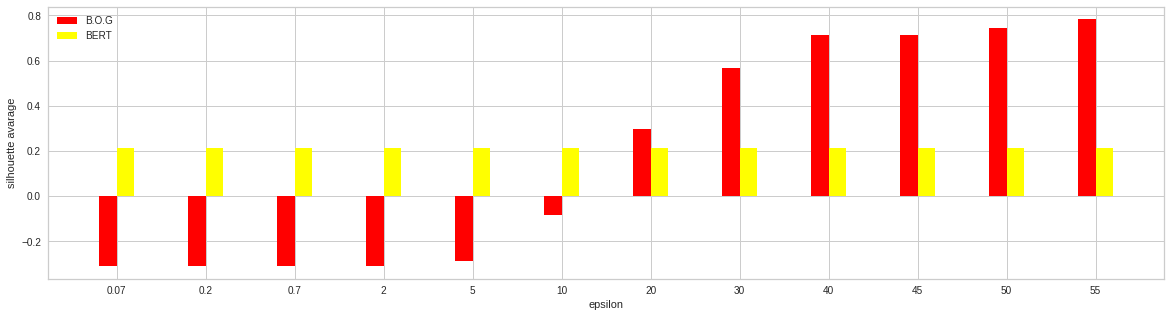

In [ ]:
plt.figure(figsize=(20,5))
x = np.arange(len(epsilon_sizes))
plt.bar(x-0.1, dbscan_evaluation, 0.2, color='red')
plt.bar(x+0.1, dbscan_based_bert_evaluation, 0.2, color='yellow')
plt.xticks(x, epsilon_sizes)
plt.xlabel("epsilon")
plt.ylabel("silhouette avarage")
plt.legend(["B.O.W.", "SBERT"])
plt.show()

<b><h3>conclusion for the first step</h3>

- DbScan did not return good enough results

<b><h3>Second Step:</h3>

the second step of this note is trying to use k-mean algorithm using some numbers of clusters and two text representation options


In [ ]:
 def KMean_evaluate(model, evaluation, input, n_clusters, graph): 
    graph.set_title('%d classes' % n_clusters)
    cluster_labels = model.fit_predict(input)
    silhouette_avg = silhouette_score(input, cluster_labels)
    evaluation.append(silhouette_avg)
    print("n_clusters: ", n_clusters, "average silhouette score is :", silhouette_avg)

    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=graph)
    visualizer.fit(input)

In [ ]:
KMean_evaluation = []
KMean_bsed_bert_evaluation = []

num_of_clusters = [*range(2, 6, 1)]
num_of_clusters_size = len(num_of_clusters)

<b>the next cell will display the result of k-mean with some different number of clusters. <br/><br/>the reviews will be represented by B.O.W. ( bag of words )

based B.O.G
n_clusters:  2 average silhouette score is : 0.24136440381341204
n_clusters:  3 average silhouette score is : 0.1375392455836522
n_clusters:  4 average silhouette score is : 0.056846749490135906
n_clusters:  5 average silhouette score is : 0.05109236679816124


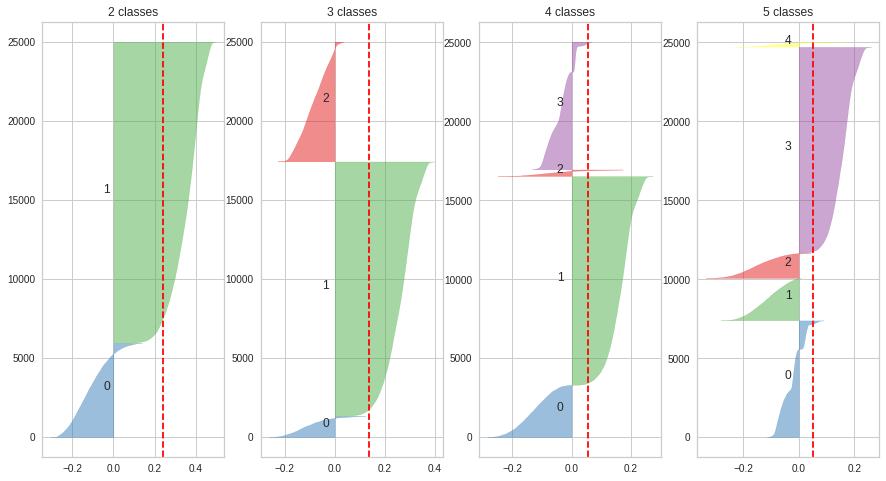

In [ ]:
fig, ax = plt.subplots(1, len(num_of_clusters), figsize=(15,8))

print("based B.O.G")
for idx, n_clusters in enumerate(num_of_clusters):
    time.sleep(2)
    model = KMeans(n_clusters=n_clusters, random_state=10)
    KMean_evaluate(model, KMean_evaluation, training_features, n_clusters, ax[idx])

<b>K-mean - B.O.W.:

- best silhouette average is in the on the 2 clusters, but the distribution of the reviews between the clusters does not make any sense - the real labels create two 2 clusters that each one is a half

- the distribution of the reviews between the clusters on the 4 and 5 clusters is better, but the silhouette average is very very small

<b>the next cell will display the result of k-mean with some different number of clusters. <br/><br/>the reviews will be represented by SBERT ( sentence BERT )

based BERT
n_clusters:  2 average silhouette score is : 0.056748524
n_clusters:  3 average silhouette score is : 0.0061752484
n_clusters:  4 average silhouette score is : 0.0045127636
n_clusters:  5 average silhouette score is : 0.0029447053


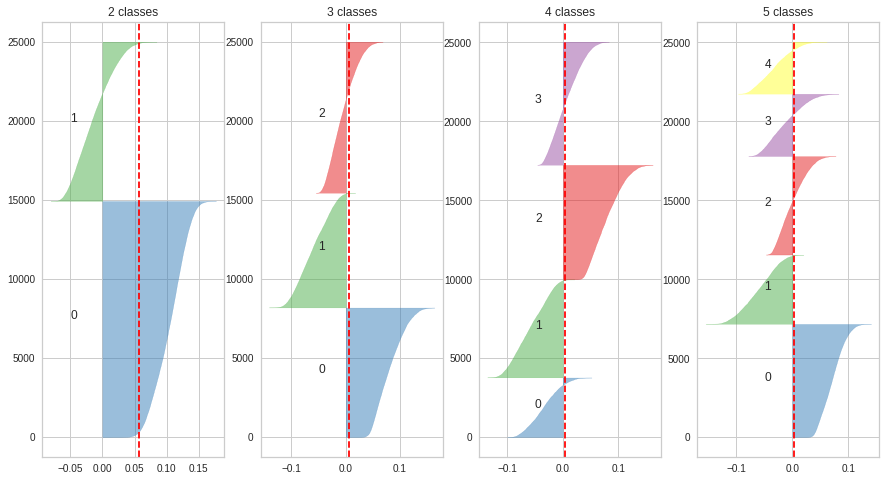

In [ ]:
fig, ax = plt.subplots(1, len(num_of_clusters), figsize=(15,8))

print("based BERT")
for idx, n_clusters in enumerate(num_of_clusters):
    time.sleep(2)
    model = KMeans(n_clusters=n_clusters, random_state=10)
    KMean_evaluate(model, KMean_bsed_bert_evaluation, embedded, n_clusters, ax[idx])

<b>K-mean - SBERT:

- all the silhouette average are very very small

<b>next cell will display the silhouette score of every cluster number for every text representation

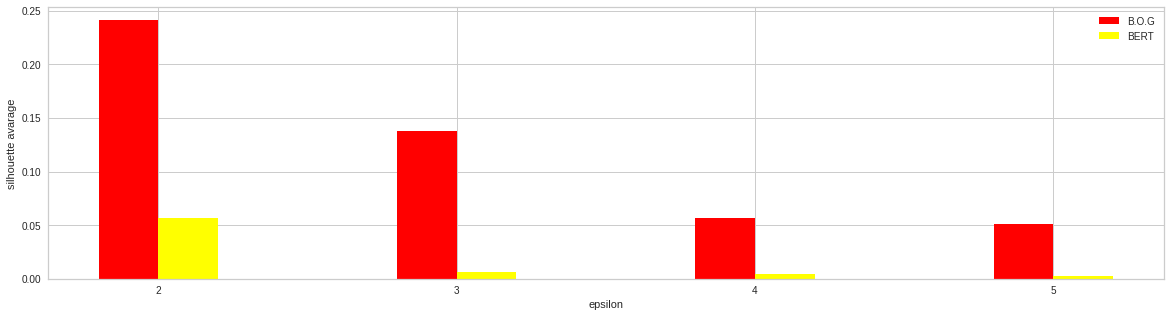

In [ ]:
plt.figure(figsize=(20,5))
x = np.arange(len(num_of_clusters))
plt.bar(x-0.1, KMean_evaluation, 0.2, color='red')
plt.bar(x+0.1, KMean_bsed_bert_evaluation, 0.2, color='yellow')
plt.xticks(x, num_of_clusters)
plt.xlabel("epsilon")
plt.ylabel("silhouette avarage")
plt.legend(["B.O.W", "BERT"])
plt.show()

<b><h3>conclusion for the second step</h3>

- the silhouette avarge of the B.O.W. gives better results than the SBERT

- the same problem with the previous section of the DbScan imbalance distribution of items into clusters